<a href="https://colab.research.google.com/github/BrunoBVR/DL-with-python/blob/main/2ndEd_8p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leveraging a pretrained model

## Feature extraction with a pretrained model

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Instantiating the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)


58900480/58889256 [==============================] - 1s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

The final feature map has shape (5, 5, 512) . That's the feature map on top of which we'll stick a densely connected classifier.

## FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION

We’ll start by extracting features as NumPy arrays by calling the predict() method of the conv_base model on our training, validation, and testing datasets.

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

In [5]:
import os, shutil, pathlib

new_base_dir = pathlib.Path("/content/drive/MyDrive/DL-With-Python/Chapter8-2ndEd/cats_vs_dogs_small")

In [6]:
train_dataset = image_dataset_from_directory(
  new_base_dir / "train",
  image_size=(180, 180),
  batch_size=32)
validation_dataset = image_dataset_from_directory(
  new_base_dir / "validation",
  image_size=(180, 180),
  batch_size=32)
test_dataset = image_dataset_from_directory(
  new_base_dir / "test",
  image_size=(180, 180),
  batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Extracting the VGG16 features and corresponding labels

In [7]:
import numpy as np

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

Defining and training the densely connected classifier:

In [10]:
inputs = keras.Input(shape=(5, 5, 512))

x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath='/content/drive/MyDrive/DL-With-Python/Chapter8-2ndEd/feature_extration.keras',
                 save_best_only=True,
                 monitor='val_loss'
             )
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/20
63/63 [==============================] - 1s 12ms/step - loss: 13.0895 - accuracy: 0.9235 - val_loss: 3.4474 - val_accuracy: 0.9750
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 3.1127 - accuracy: 0.9780 - val_loss: 4.7985 - val_accuracy: 0.9740
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 2.4159 - accuracy: 0.9805 - val_loss: 4.4297 - val_accuracy: 0.9780
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 1.1829 - accuracy: 0.9895 - val_loss: 4.4640 - val_accuracy: 0.9760
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 0.5704 - accuracy: 0.9945 - val_loss: 3.6509 - val_accuracy: 0.9750
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 0.9631 - accuracy: 0.9930 - val_loss: 8.4921 - val_accuracy: 0.9650
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 0.2927 - accuracy: 0.9970 - val_loss: 5.2703 - val_accuracy: 0.9750
Epoch 8/20
63/63 

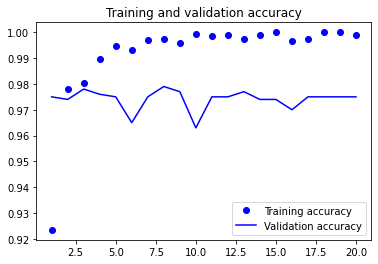

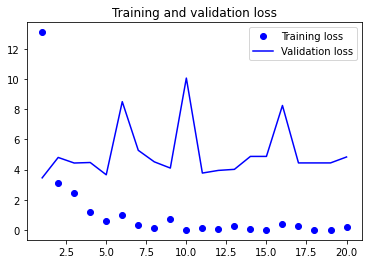

In [11]:
# Plotting results
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## FAST FEATURE EXTRACTION WITH DATA AUGMENTATION

In [12]:
# Instantiating and freezing the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
  weights="imagenet",
  include_top=False)
conv_base.trainable = False

In [13]:
# Printing the list of trainable weights before and after freezing
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights before freezing the conv base: 26


In [14]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [15]:
# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2),
    ]
)


inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)

x = keras.applications.vgg16.preprocess_input(x)

x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/DL-With-Python/Chapter8-2ndEd/feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 21s 298ms/step - loss: 23.1177 - accuracy: 0.8915 - val_loss: 6.6233 - val_accuracy: 0.9640
Epoch 2/50
63/63 [==============================] - 19s 289ms/step - loss: 7.8178 - accuracy: 0.9440 - val_loss: 4.8225 - val_accuracy: 0.9760
Epoch 3/50
63/63 [==============================] - 19s 291ms/step - loss: 6.5728 - accuracy: 0.9520 - val_loss: 4.1128 - val_accuracy: 0.9780
Epoch 4/50
63/63 [==============================] - 19s 292ms/step - loss: 7.1245 - accuracy: 0.9540 - val_loss: 5.2448 - val_accuracy: 0.9760
Epoch 5/50
63/63 [==============================] - 19s 291ms/step - loss: 5.2002 - accuracy: 0.9580 - val_loss: 5.5322 - val_accuracy: 0.9740
Epoch 6/50
63/63 [==============================] - 19s 291ms/step - loss: 4.0422 - accuracy: 0.9655 - val_loss: 7.3059 - val_accuracy: 0.9660
Epoch 7/50
63/63 [==============================] - 19s 291ms/step - loss: 4.2272 - accuracy: 0.9715 - val_loss: 3.6260 - val_accuracy: 0.976

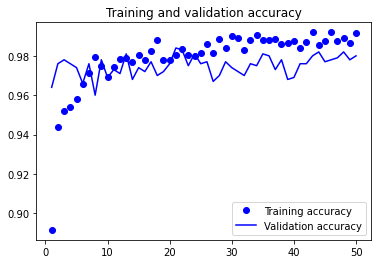

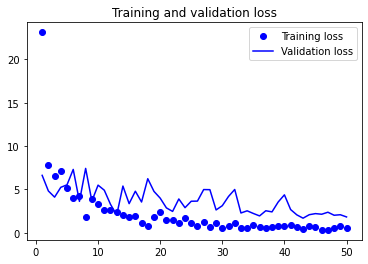

In [17]:
# Plotting results
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [18]:
# Evaluating the model on the test set
test_model = keras.models.load_model(
"/content/drive/MyDrive/DL-With-Python/Chapter8-2ndEd/feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 12s 181ms/step - loss: 2.7318 - accuracy: 0.9760
Test accuracy: 0.976


## Fine-tuning a pretrained model

In [19]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

We’ll fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozen, and the layers block5_conv1 , block5_conv2 , and block5_conv3 should be trainable.

In [20]:
# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [21]:
# Fine-tuning
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
  keras.callbacks.ModelCheckpoint(
      filepath="/content/drive/MyDrive/DL-With-Python/Chapter8-2ndEd/fine_tuning.keras",
      save_best_only=True,
      monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 24s 325ms/step - loss: 0.2107 - accuracy: 0.9935 - val_loss: 1.6643 - val_accuracy: 0.9820
Epoch 2/30
63/63 [==============================] - 21s 318ms/step - loss: 0.5774 - accuracy: 0.9890 - val_loss: 2.4017 - val_accuracy: 0.9780
Epoch 3/30
63/63 [==============================] - 21s 323ms/step - loss: 0.5853 - accuracy: 0.9915 - val_loss: 2.2949 - val_accuracy: 0.9750
Epoch 4/30
63/63 [==============================] - 21s 320ms/step - loss: 0.3216 - accuracy: 0.9920 - val_loss: 2.1730 - val_accuracy: 0.9780
Epoch 5/30
63/63 [==============================] - 21s 321ms/step - loss: 0.2219 - accuracy: 0.9930 - val_loss: 2.3205 - val_accuracy: 0.9780
Epoch 6/30
63/63 [==============================] - 21s 321ms/step - loss: 0.4765 - accuracy: 0.9905 - val_loss: 2.3194 - val_accuracy: 0.9750
Epoch 7/30
63/63 [==============================] - 21s 320ms/step - loss: 0.2314 - accuracy: 0.9930 - val_loss: 2.8915 - val_accuracy: 0.9730

In [23]:
model = keras.models.load_model("/content/drive/MyDrive/DL-With-Python/Chapter8-2ndEd/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 12s 182ms/step - loss: 1.4083 - accuracy: 0.9770
Test accuracy: 0.977
